## Some Standard imports

In [ ]:
!pip install pycaret==2.3.10

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pycaret-2.3.10-py3-none-any.whl (320 kB)
  Using cached scikit-learn-0.23.2.tar.gz (7.2 MB)


In [1]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import StratifiedKFold

In [3]:
from pycaret.classification import *

ModuleNotFoundError: No module named 'pycaret'

In [14]:
from google.colab import files

In [15]:
from sklearn.metrics import auc
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22, 'font.family': 'Times'})

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [26]:
conf = 'timeto'
if conf == 'timeto':
  cutpts_arr = [240, 1440, 2880, 4320, 7200, 10080, 14400]
  title = 'of ICU data'
  new_names = ['4 hours', '1 day', '2 days', '3 days', '5 days', '7 days', '10 days']
else:
  cutpts_arr = [240, 1440, 2880, 4320, 7200, 10080, 14400]
  title = 'before verapamil injection'
  new_names = ['4 hours', '1 day', '2 days', '3 days', '5 days', '7 days', '10 days']

In [27]:
data_pts = []
for T in cutpts_arr:
  for ftype in ['normal', 'nocount', 'lr']:
    # read in the file. NOTE: You must upload to the colab directory
    fig_basestr = ''
    if ftype == 'lr':
      fstring = f'{T}.csv'
      fig_basestr = f'{T}_lr'
    elif ftype == 'nocount':
      fstring = f'{T}_nocounts.csv'
      fig_basestr = f'{T}_count-False'
    else:
      fstring = f'{T}.csv'
      fig_basestr = f'{T}_phys-False'
    df = pd.read_csv(fstring)
    print(len(df.columns))
    for idx, c in enumerate(df.columns):
      if c == "('MEAS_VALUE', 'ICP')_x":
        print("found! at idx = ", idx)
        print(df.drop(columns=[df.columns[idx]], inplace=True))
    print(len(df.columns))

    
    df.loc[:,'VERAPAMIL_TAKEN'].value_counts().to_csv(f'{fig_basestr}-valcounts.csv')
    print(df.loc[:,'VERAPAMIL_TAKEN'].value_counts())
    skf = StratifiedKFold(n_splits=5)
    target = df.loc[:,'VERAPAMIL_TAKEN']
    splits = [x for x in skf.split(df, target)]

    models = []
    predictions = []
    importances = []

    for idx in range(len(splits)):
      setup(data=df.loc[splits[idx][0],:], target='VERAPAMIL_TAKEN', verbose=True, 
              fix_imbalance=True, log_experiment=False,
              ignore_features=['HSH_ADMSN_ID', 'Unnamed: 0'],
              experiment_name='adv1', fold=5, test_data=df.loc[splits[idx][1],:])
      models_filt = ['lightgbm', 'lr']
      if ftype == 'lr':
        models_filt = ['lr']
      else:
        models_filt = ['lightgbm']
      topmodels = compare_models(include=models_filt, n_select = len(models_filt))
      out = predict_model(topmodels)
      predictions.append(out)
      if ftype != 'lr':
        importance = pd.DataFrame({'Feature': get_config('X_train').columns, 
                                    'Value' : abs(
                                        topmodels.feature_importances_
                                        )}).sort_values(by='Value', ascending=False)
        importances.append(importance)
      models.append(topmodels)
    # PLOT AUC
    plt.figure()

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    best_fold = 0
    best_auc = -1
    for idx in range(5):
      y_test = [(1 if x == "True" else 0) for x in predictions[idx]['VERAPAMIL_TAKEN'].array]
      y_labels = list(predictions[idx]['Label'].array)
      pred_scores = list(predictions[idx]['Score'].array)
      y_pred = []
      print(pred_scores)
      for idj, j in enumerate(y_test):
        if (y_labels[idj] == "False"):
          y_pred.append(1-pred_scores[idj])
        else:
          y_pred.append(pred_scores[idj])
      print(y_pred)
      fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
      roc_auc = metrics.auc(fpr, tpr)
      # method I: plt
      # plt.title(f'ROC Curve (T={T} min pre-VERAPAMIL)', fontsize=20)
      # plt.plot(fpr, tpr, label = f'Fold {idx}: AUC = %0.3f' % (roc_auc), alpha=0.2)

      interp_tpr = np.interp(mean_fpr, fpr, tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)
      if (roc_auc) > best_auc:
        best_auc = roc_auc
        best_fold = idx
      aucs.append(roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    # THIS IS WHAT YOU USE TO PLOT
    
    # plt.plot(
    #     np.linspace(0, 1, 100),
    #     mean_tpr,
    #     label=r"Mean ROC @T=%d min (AUC = %0.2f $\pm$ %0.2f)" % (T, mean_auc, std_auc),
    #     lw=2,
    #     alpha=0.8,
    # )
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    data_pts.append({
        'type': 'ROC',
        'T': T,
        'criteria': ftype,
        'x': mean_fpr,
        'y': mean_tpr,
        'AUC': mean_auc,
        'std_auc': std_auc,
        'upper_y': tprs_upper,
        'lower_y': tprs_lower
    })
    

    ## Var Imp
    if ftype != 'lr':
      fig = plt.figure()
      var_imp = pd.concat(importances).groupby('Feature').sum().sort_values(by='Value', ascending=False).reset_index()
      scaler = MinMaxScaler()
      var_imp['scaled'] = scaler.fit_transform(var_imp['Value'].values.reshape(-1,1))
      var_imp[:10].to_csv(f'{fig_basestr}-varimp.csv')
      ax = var_imp[:10].plot(kind='barh', x='Feature', y='scaled')

      # ax = importances[best_fold][:10].plot(kind='barh', x='Feature')
      ax.invert_yaxis()
      ax.set_title(f"Variable Importances ({T} Min)", fontsize=20)
      plt.savefig(f"{fig_basestr}-varimp.png", bbox_inches='tight')


    # PR Curve
    # plt.figure()

    y_real = []
    y_proba = []

    for idx in range(5):
      y_test = [(1 if x == "True" else 0) for x in predictions[idx]['VERAPAMIL_TAKEN'].array]
      y_labels = list(predictions[idx]['Label'].array)
      pred_scores = list(predictions[idx]['Score'].array)
      y_pred = []
      for idj, j in enumerate(y_test):
        if (y_labels[idj] == "False"):
          y_pred.append(1-pred_scores[idj])
        else:
          y_pred.append(pred_scores[idj])
      precision, recall, _ = precision_recall_curve(y_test, y_pred)
      average_precision = average_precision_score(y_test, y_pred, average="micro")
      # plt.plot(recall, precision, alpha=0.2, label=f'Fold {idx}: AP = %0.3f' % (average_precision))
      print(len(precision), len(recall))
      y_real.append(y_test)
      y_proba.append(y_pred)

    y_real = np.concatenate(y_real)
    y_proba = np.concatenate(y_proba)
    precision, recall, _ = precision_recall_curve(y_real, y_proba)
    std_prec = np.std(precision)
    prec_upper = np.minimum(precision + std_prec, 1)
    prec_lower = np.maximum(precision - std_prec, 0)

    # plt.fill_between(
    #     recall,
    #     prec_lower,
    #     prec_upper,
    #     color="grey",
    #     alpha=0.2,
    #     label=r"$\pm$ 1 std. dev.",
    # )


    # lab = 'Overall AP=%.3f $\pm$ %.3f' % (auc(recall, precision), std_prec)
    data_pts.append({
        'type': 'PR',
        'T': T,
        'criteria': ftype,
        'x': recall,
        'y': precision,
        'AUC': auc(recall, precision),
        'std_auc': std_prec,
        'upper_y': prec_upper,
        'lower_y': prec_lower
    })
    # plt.step(recall, precision, label=lab, lw=2, color='black')


    # plt.legend(loc = 'lower right', frameon=True, prop={"size":12})

# PLOT FSCORES
    # f_scores = np.linspace(0.2, 0.8, num=4)
    # lines = []
    # labels = []
    # for f_score in f_scores:
    #     x = np.linspace(0.01, 1)
    #     y = f_score * x / (2 * x - f_score)
    #     l, = plt.plot(x[y >= 0], y[y >= 0], color='black', linestyle='dotted', alpha=0.2)
    #     plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02), fontsize=12)

    # plt.xlabel('Recall')
    # plt.ylabel('Precision')
    # plt.legend(loc="lower left")
    # plt.ylim([0.0, 1.05])
    # plt.xlim([0.0, 1.0])
    stats = {"recall": recall, "precision": precision}
    # plt.savefig(f"{fig_basestr}-pr_roc.png")
    pd.DataFrame(stats).to_csv(f'{fig_basestr}-stats.csv')


    # files.download(f'{fig_basestr}-roc.png') 
    # files.download(f'{fig_basestr}-pr_roc.png')
    if ftype != 'lr':
      files.download(f'{fig_basestr}-varimp.png')
    files.download(f'{fig_basestr}-stats.csv')
    files.download(f'{fig_basestr}-valcounts.csv')


231
found! at idx =  203
None
230
False    1817
True      125
Name: VERAPAMIL_TAKEN, dtype: int64


ValueError: ignored

In [ ]:
import json

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


with open("data.json", "w") as write_file:
    json.dump(data_pts, write_file, cls=NpEncoder, indent=4)

In [ ]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# Set the default color cycle
import matplotlib.pylab as pl
colors = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
plt.rcParams.update({'font.size': 22, 'font.family': 'DejaVu Serif'})

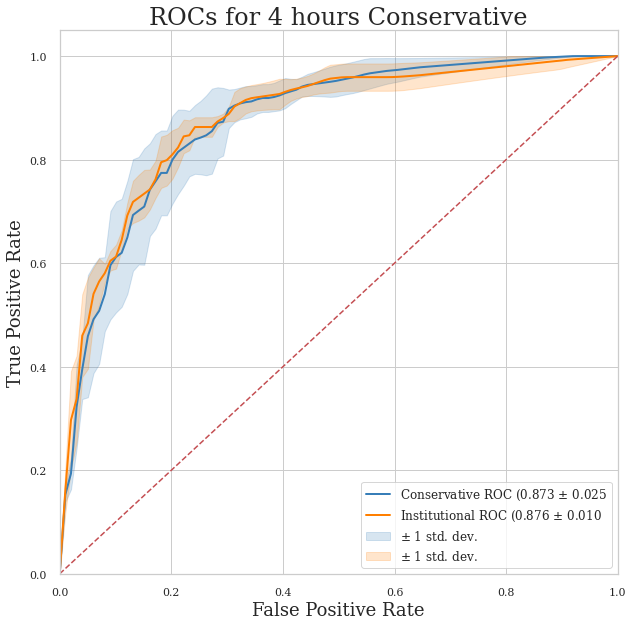

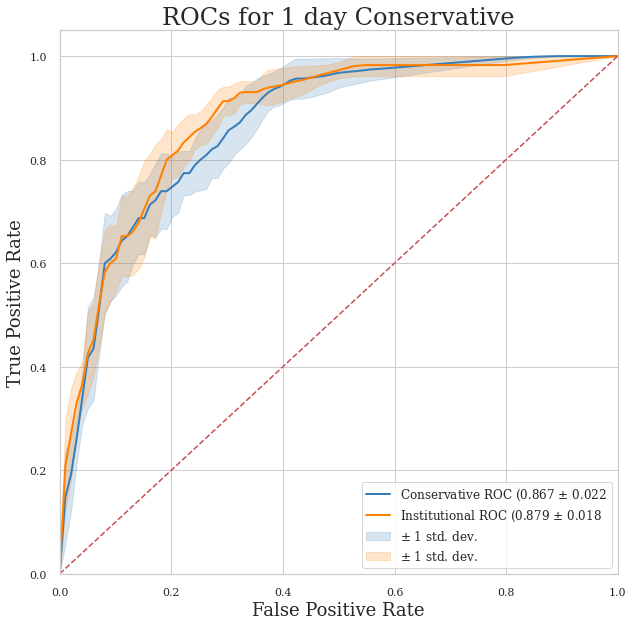

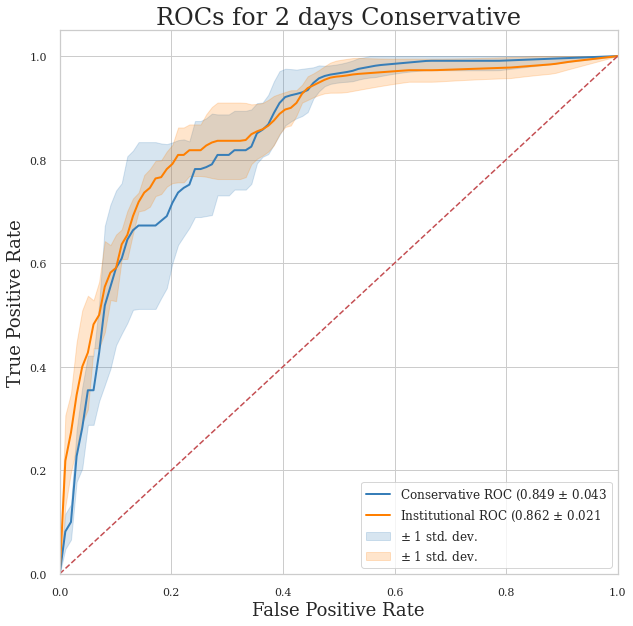

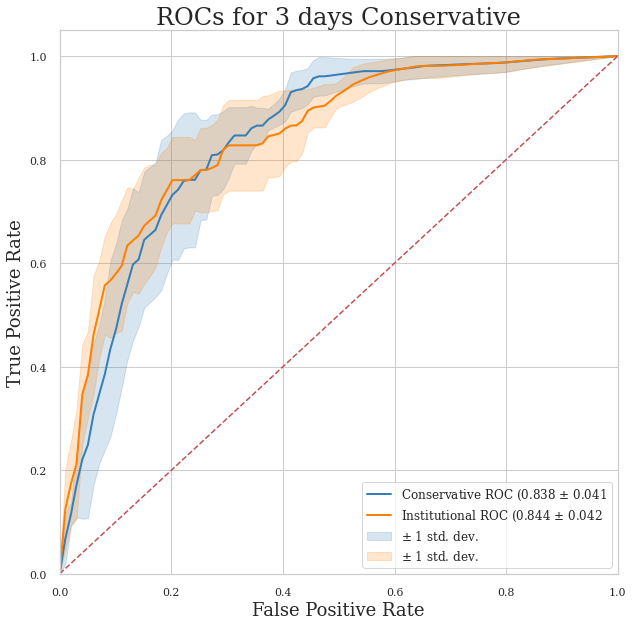

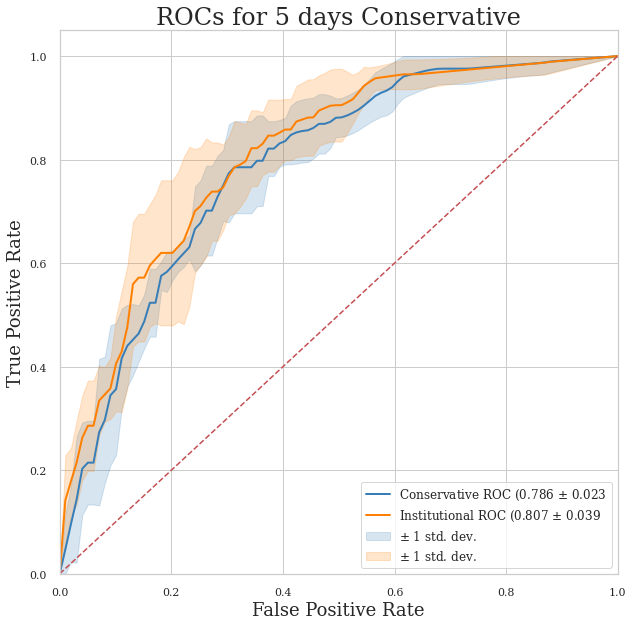

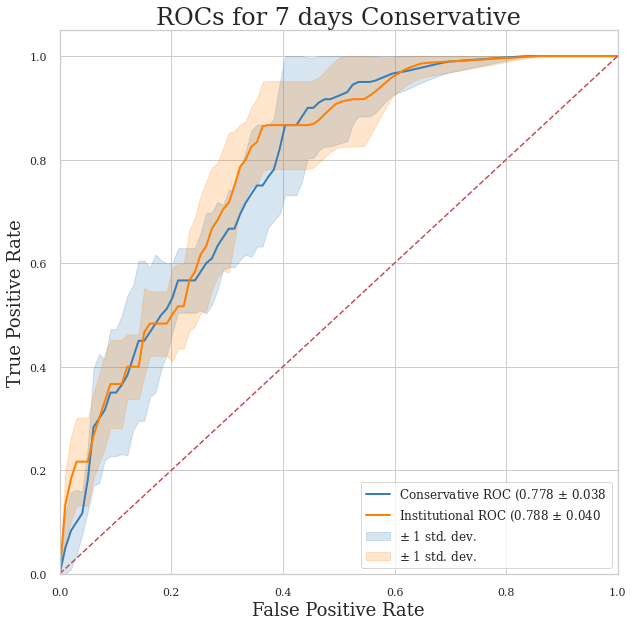

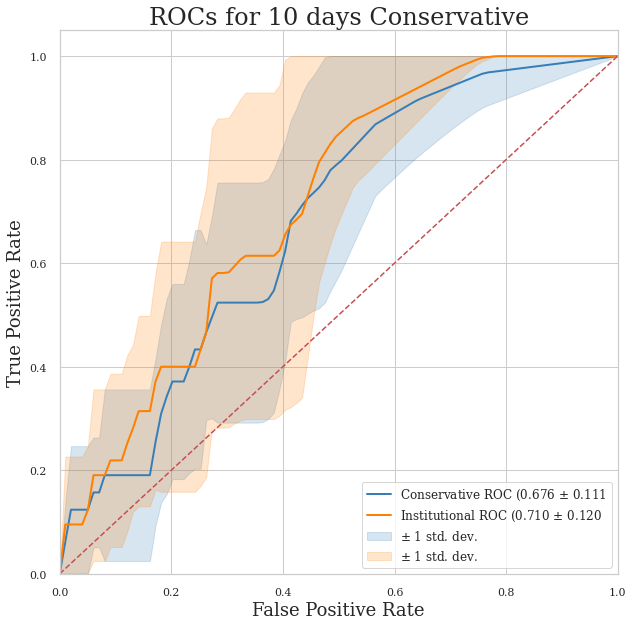

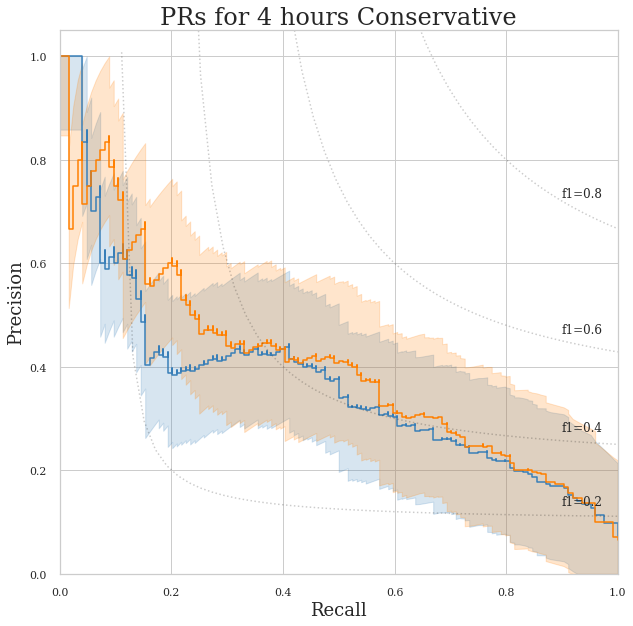

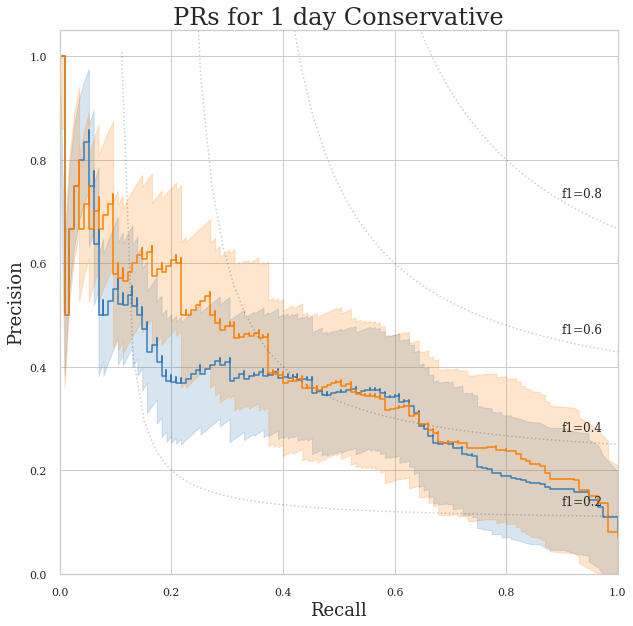

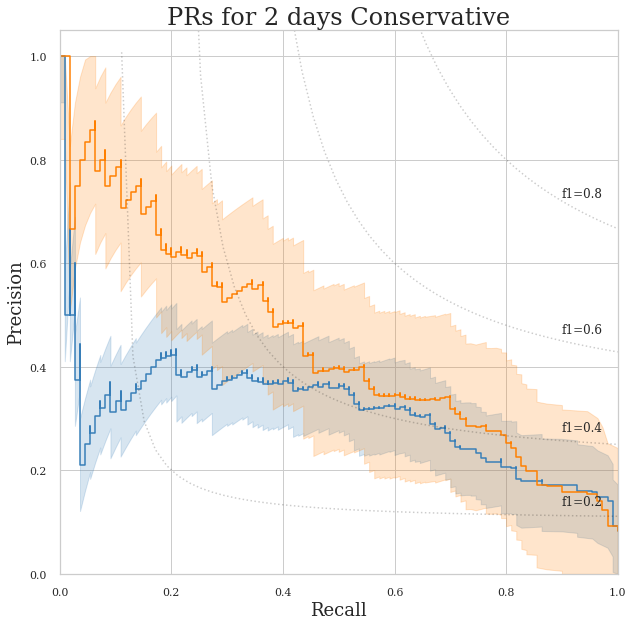

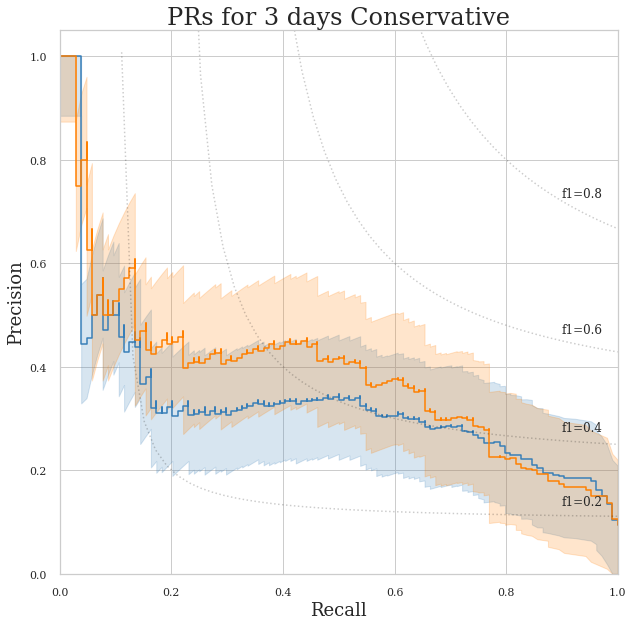

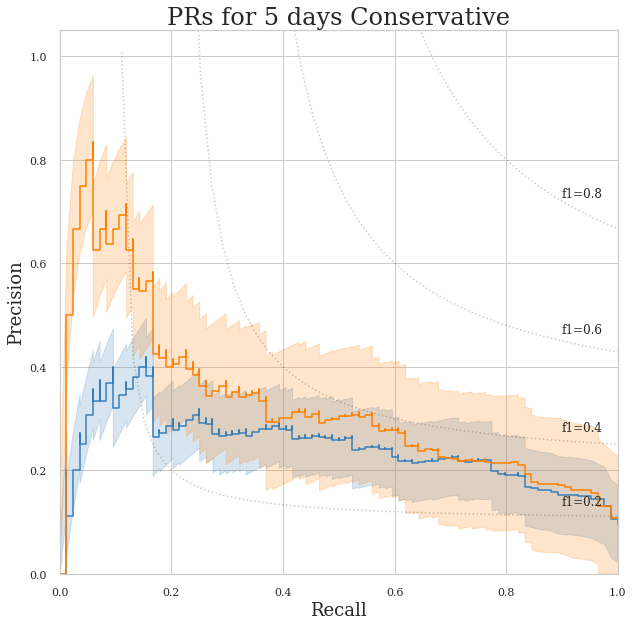

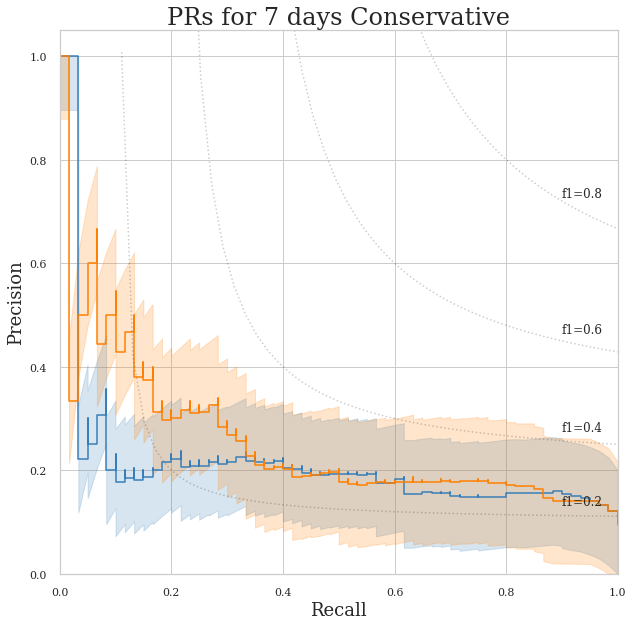

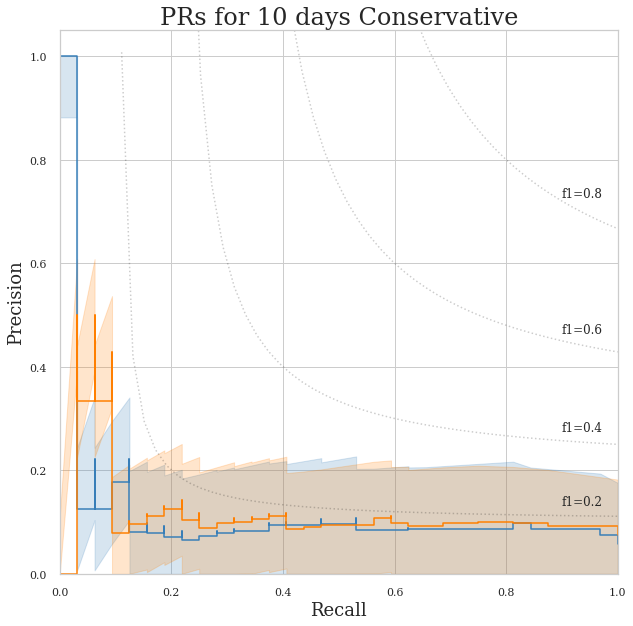

In [ ]:
for graph in ['ROC', 'PR']:
  for idc, crit in enumerate(cutpts_arr):
    
    plt.figure(figsize=(10,10))
    filt_data = list(filter(lambda x: x['type'] == graph and x['T'] == crit and x['criteria'] != 'lr', data_pts))
    sorted_data = sorted(filt_data, key=lambda x: x['criteria'])
    for idx, t in enumerate(sorted_data):
      model_name = "Institutional" if t['criteria'] == 'normal' else "Conservative"
      if graph == 'PR':
        plt.step(
            t['x'],
            t['y'],
            label=f'{model_name} AP ({t["AUC"]:.3f} $\pm$ {t["std_auc"]:.3f}',
            color=colors[idx]
        )
        plt.fill_between(
            t['x'],
            t['upper_y'],
            t['lower_y'],
            color=colors[idx],
            alpha=0.2,
            label=r"$\pm$ 1 std. dev.",
        )
      else:
        plt.plot(
              t['x'],
              t['y'],
              label=f'{model_name} ROC ({t["AUC"]:.3f} $\pm$ {t["std_auc"]:.3f}',
              lw=2, 
              color=colors[idx]
        )
        plt.fill_between(
            t['x'],
            t['upper_y'],
            t['lower_y'],
            color=colors[idx],
            alpha=0.2,
            label=r"$\pm$ 1 std. dev.",
        )
    if graph == 'ROC':
      plt.legend(loc = f'lower {"right" if graph == "ROC" else "left"}', frameon=True, prop={"size":12})
    if graph == 'ROC':
      plt.plot([0, 1], [0, 1],'r--')
    else:
      f_scores = np.linspace(0.2, 0.8, num=4)
      lines = []
      labels = []
      for f_score in f_scores:
          x = np.linspace(0.01, 1)
          y = f_score * x / (2 * x - f_score)
          l, = plt.plot(x[y >= 0], y[y >= 0], color='black', linestyle='dotted', alpha=0.2)
          plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02), fontsize=12)
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    if graph == 'ROC':
      plt.ylabel('True Positive Rate', fontsize=18)
      plt.xlabel('False Positive Rate', fontsize=18)
    else: 
      plt.ylabel('Precision', fontsize=18)
      plt.xlabel('Recall', fontsize=18)
    plt.savefig(f"{fig_basestr}-roc.png")

    
    plt.title(f'{graph}s for {new_names[idc]}', fontsize=24)
    plt.savefig(f'new_{graph}_{crit}.png', dpi=300, bbox_inches='tight')
    plt.plot()
    

In [ ]:
obj = []

for t in ['normal', 'nocount', 'lr']:
  filt = list(filter(lambda d: d['criteria'] == t, data_pts))
  
  filt_auc = sorted(list(filter(lambda d: d['type'] == 'ROC', filt)), key=lambda k: k['T'])
  filt_pr = sorted(list(filter(lambda d: d['type'] == 'PR', filt)), key=lambda k: k['T'])
  for idx, x in enumerate(filt_auc):
    if x['T'] < 20160:
      obj.append({
        'time': x['T'],
        'AUC': x['AUC'],
        'precision': sorted(list(filter(lambda p: p[0] == 1, zip(filt_pr[idx]['x'], filt_pr[idx]['y']))), key=lambda p: p[1])[-1][1],
        'recall': sorted(list(filter(lambda p: p[1] == 1, zip(filt_pr[idx]['x'], filt_pr[idx]['y']))), key=lambda p: p[0])[-1][0],
        'type': t
      })


In [ ]:
obj_df = pd.DataFrame(obj)

In [ ]:
obj_df = obj_df.replace(cutpts_arr, new_names)

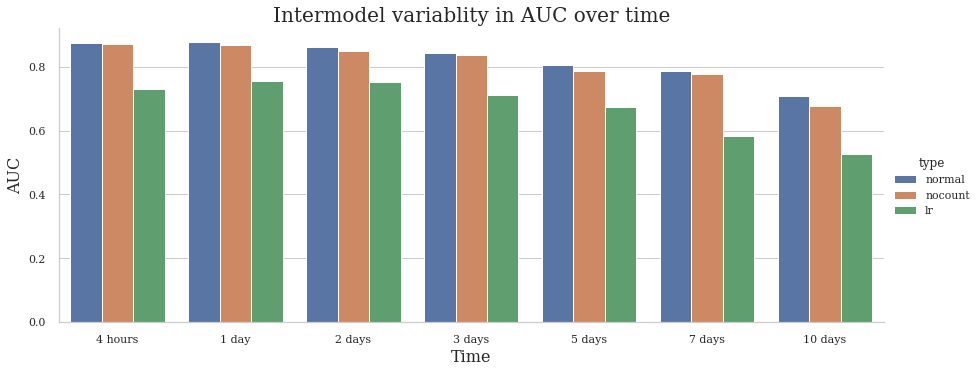

In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid", font="DejaVu Serif")
g = sns.catplot(
    data=obj_df, kind="bar",
    x="time", y="AUC", hue="type",
    height=5, aspect=20.7/8.27
)
plt.xlabel("Time", fontsize=16)
plt.ylabel('AUC', fontsize=16)
plt.title("Intermodel variablity in AUC over time", fontsize=20)
plt.savefig("new_AUC_multiple_models.png",  dpi=300, bbox_inches='tight')

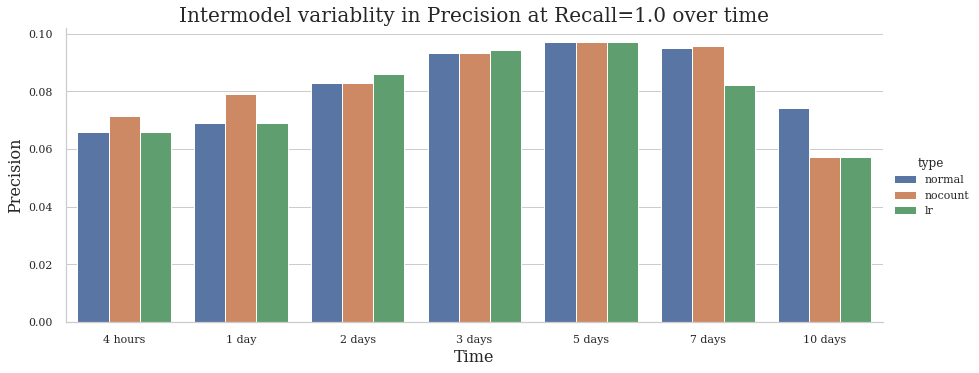

In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid" , font="DejaVu Serif")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=obj_df, kind="bar",
    x="time", y="precision", hue="type",
    height=5, aspect=20.7/8.27
)
plt.xlabel("Time", fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.title("Intermodel variablity in Precision at Recall=1.0 over time", fontsize=20)
plt.savefig("new_precision_multiple_models.png", dpi=300, bbox_inches='tight')

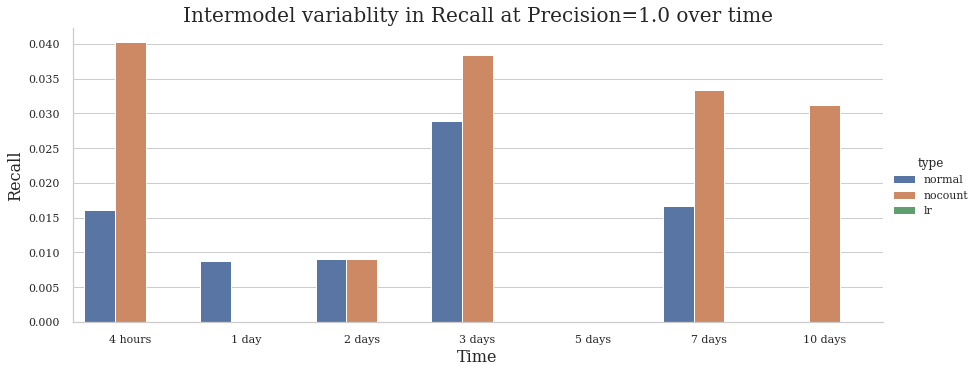

In [ ]:
import seaborn as sns

sns.set_theme(style="whitegrid" , font="DejaVu Serif")

# Draw a nested barplot by species and sex
g = sns.catplot(
    data=obj_df, kind="bar",
    x="time", y="recall", hue="type",
    height=5, aspect=20.7/8.27
)
plt.xlabel("Time", fontsize=16)
plt.ylabel('Recall', fontsize=16)
plt.title("Intermodel variablity in Recall at Precision=1.0 over time", fontsize=20)
plt.savefig("new_Recall_multiple_models.png", dpi=300, bbox_inches='tight')

In [ ]:
obj_df.to_csv("new_table_data.csv")

In [ ]:
names = pd.read_csv('david_predictors.csv')

In [ ]:
names['HSH_ADMSN_ID'] = names.HSH_ADMSN_ID.str.replace("'", '')
names['HSH_ADMSN_ID'] = names.HSH_ADMSN_ID.str.replace(",", '')

In [ ]:
names

,HSH_ADMSN_ID,physiologic,Non-physiologic,map
0,((ORD_NUM_VALUE_CORRECTED min) ALBUMIN SERUM),1.0,NaN,"min, ALBUMIN, SERUM"
1,((ORD_NUM_VALUE_CORRECTED min) BASE EXCESS),1.0,NaN,"min, BASE EXCESS"
2,((ORD_NUM_VALUE_CORRECTED min) BASOPHILS),1.0,NaN,"min, BASOPHILS"
3,((ORD_NUM_VALUE_CORRECTED min) C-REACTIVE PROT...,1.0,NaN,"min, C-REACTIVE PROTEIN"
4,((ORD_NUM_VALUE_CORRECTED min) CHLORIDE SERUM),1.0,NaN,"min, CHLORIDE, SERUM"
...,...,...,...,...
222,(MEAS_VALUE Supplemental ETCO2)_y,NaN,NaN,Supplemental ETCO2 was measured true/false
223,(MEAS_VALUE Supplemental FIO2)_y,NaN,NaN,Supplemental FIO2 was measured true/false
224,(MEAS_VALUE Supplemental O2)_y,NaN,NaN,Supplemental O2 was measured true/false
225,(MEAS_VALUE TUBE FEEDING)_y,1.0,NaN,TUBE FEEDING was measured true/false


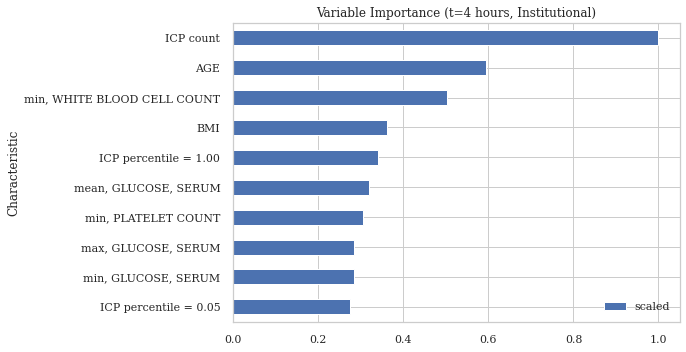

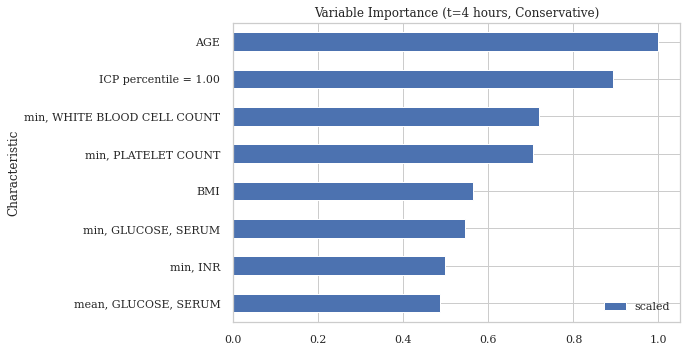

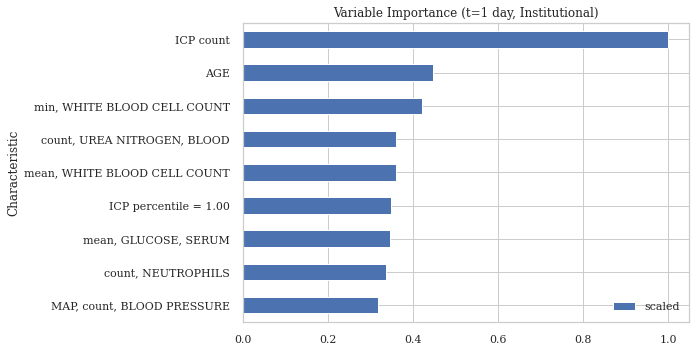

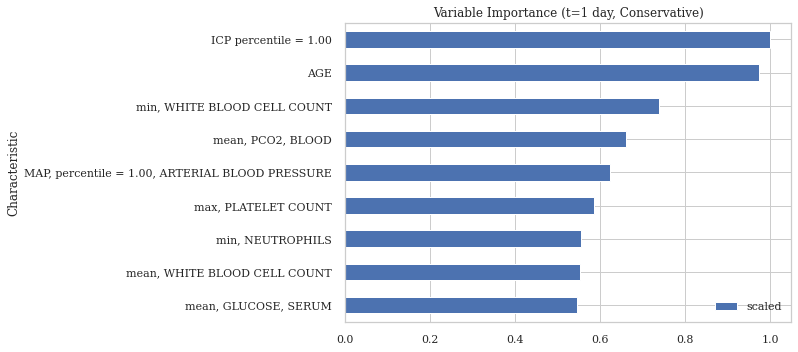

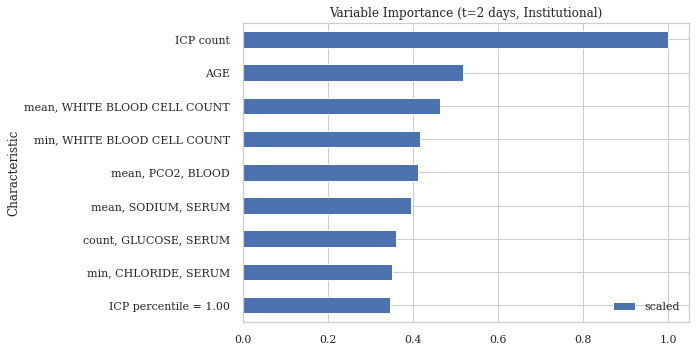

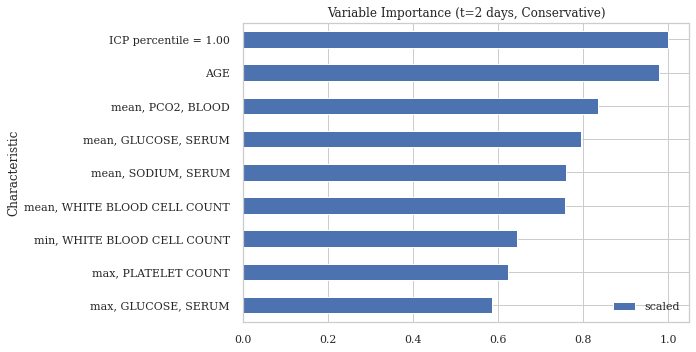

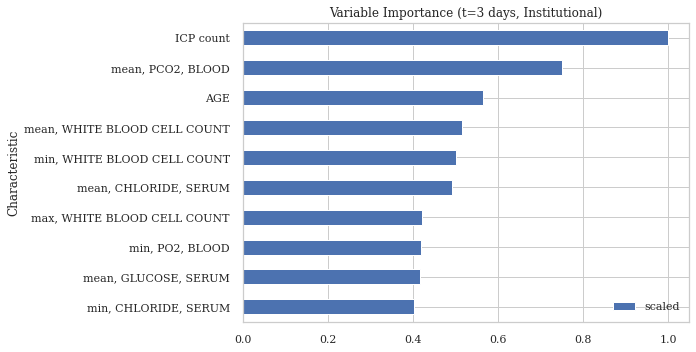

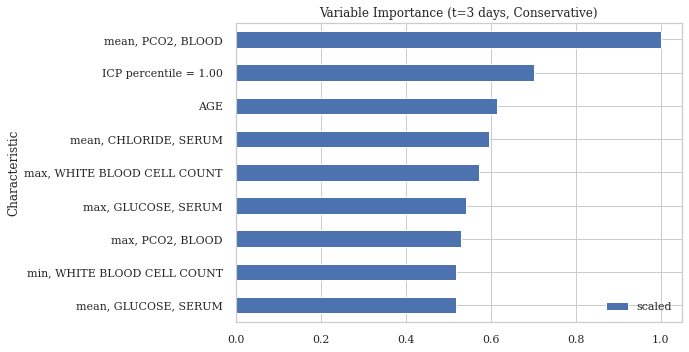

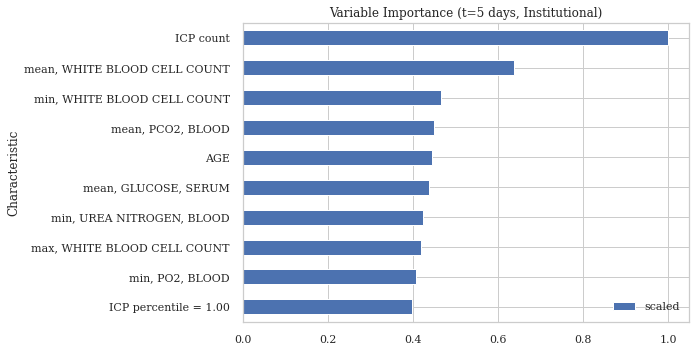

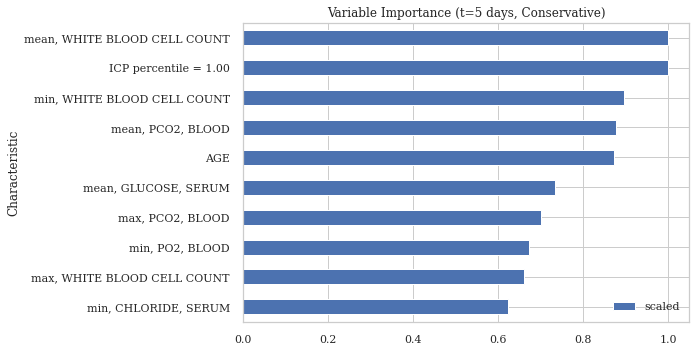

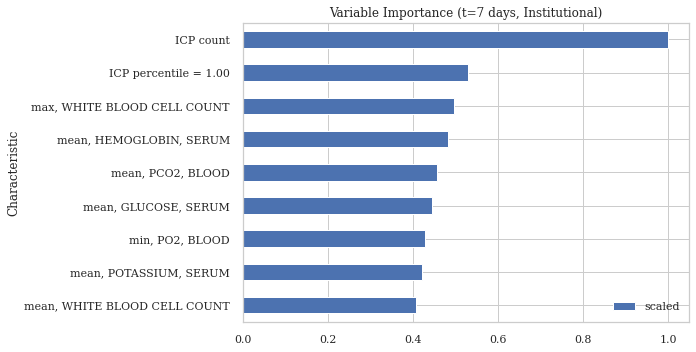

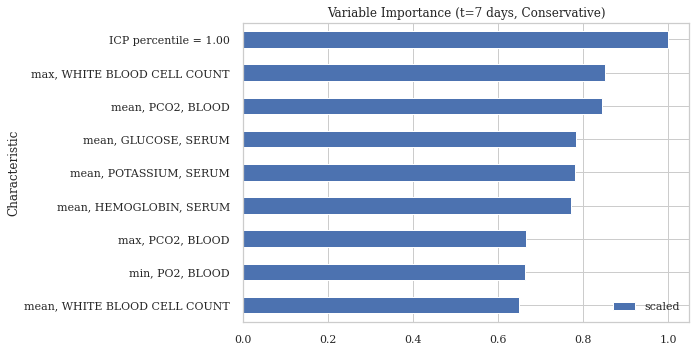

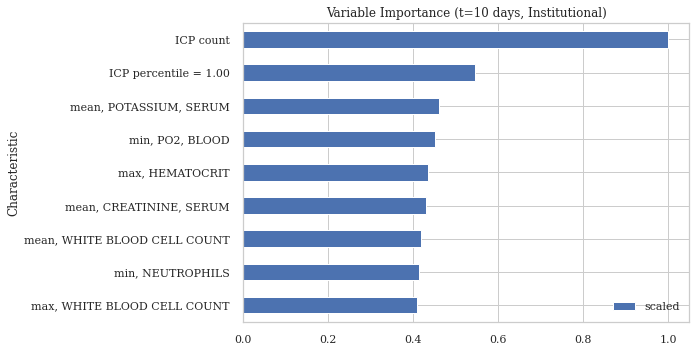

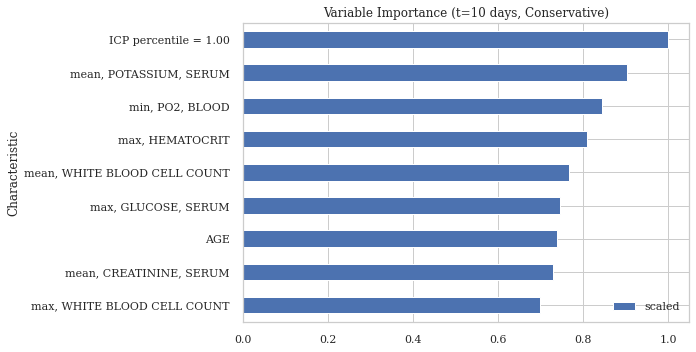

In [ ]:
for idx, t in enumerate(cutpts_arr):
  times = new_names
  for v in ['phys-False', 'count-False']:
    df = pd.read_csv(f"{t}_{v}-varimp.csv").sort_values(by='scaled', ascending=False).merge(names, left_on='Feature', right_on='HSH_ADMSN_ID')
    ax = df.plot.barh(x='map', y='scaled')
    ax.invert_yaxis()
    ax.set_ylabel('Characteristic')
    title = "Institutional" if v == "phys-False" else "Conservative"
    ax.set_title(f'Variable Importance (t={times[idx]}, {title})')
    plt.savefig(f"new_{t}_varimp_{title}_final.png", dpi=300, bbox_inches='tight')

In [ ]:
!rm results.zip
!zip results.zip *_count-False-valcounts.csv new_table_data.csv ./new_*.png ./*.json

  adding: 10080_count-False-valcounts.csv (stored 0%)
  adding: 14400_count-False-valcounts.csv (stored 0%)
  adding: 1440_count-False-valcounts.csv (stored 0%)
  adding: 240_count-False-valcounts.csv (stored 0%)
  adding: 2880_count-False-valcounts.csv (stored 0%)
  adding: 4320_count-False-valcounts.csv (deflated 3%)
  adding: 7200_count-False-valcounts.csv (stored 0%)
  adding: new_table_data.csv (deflated 60%)
  adding: new_10080_varimp_Conservative_final.png (deflated 19%)
  adding: new_10080_varimp_Institutional_final.png (deflated 19%)
  adding: new_14400_varimp_Conservative_final.png (deflated 19%)
  adding: new_14400_varimp_Institutional_final.png (deflated 19%)
  adding: new_1440_varimp_Conservative_final.png (deflated 20%)
  adding: new_1440_varimp_Institutional_final.png (deflated 19%)
  adding: new_240_varimp_Conservative_final.png (deflated 20%)
  adding: new_240_varimp_Institutional_final.png (deflated 19%)
  adding: new_2880_varimp_Conservative_final.png (deflated 19%)


In [ ]:
files.download('results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>